In [1]:
import csv
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

from io import StringIO
import requests

In [2]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [3]:
from io import StringIO
import requests

def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [4]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

In [5]:
df_train_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52675 entries, 0 to 52674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   52675 non-null  object
 1   label   52675 non-null  object
dtypes: object(2)
memory usage: 823.2+ KB


In [6]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


In [7]:
df_train_dev.label.unique()

array(['ar', 'ar_LATN', 'az', 'bg', 'bn', 'bs', 'ca', 'cs', 'cy', 'da',
       'de', 'dv', 'el', 'en', 'es', 'et', 'fa', 'fi', 'fr', 'gl', 'ha',
       'he', 'hi', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'id', 'is', 'it',
       'ja', 'ja_LATN', 'jv', 'km', 'ko', 'ko_LATN', 'ms', 'ne', 'nl',
       'no', 'pl', 'ps', 'ps_LATN', 'pt', 'ro', 'ru', 'si', 'sl', 'sq',
       'sr', 'su', 'sv', 'sw', 'ta', 'ta_LATN', 'th', 'tl', 'tn', 'tr',
       'uk', 'und', 'ur', 'ur_LATN', 'vi', 'wo', 'xh', 'zh-CN', 'zh-TW'],
      dtype=object)

In [8]:
X_train = df_train_dev.tweet
y_train = df_train_dev.label
X_test = df_test.tweet
y_test = df_test.label

In [9]:
#vectorizing labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
le_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [10]:
#calculating the length of the tweets
def length(text):
  return len(text)

#get max word length for a given sentence
def get_max_wordlength(text):
  text_list=[len(word) for word in text.split()]
  max=np.ceil(np.max(text_list))
  return max

#get average word length for a given tweet
def get_average_word_length(text):
  text_list=[len(word) for word in text.split()]
  mean=np.ceil(np.mean(text_list))
  return mean

#get count of spaces in the given tweet
def get_total_spaces(text):
  space_count=len([word for word in text.split() if word==" "])
  return space_count

In [11]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import re
import string
import emoji
exclude = string.punctuation


#lowercasing, removing html tags, urlss, punctuations and emojis
def convert_lowercase(column):
    column = column.str.lower()
    return column

def remove_html_tags(text):
    re_html = re.compile('<.*?>')
    return re_html.sub(r'', text)

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

def remove_special(text):
    x=''
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x

def perform_stemming(text):
    new_text = [ps.stem(word) for word in text.split()]
    return ' '.join(new_text)

def remove_digits(text):
    filtered_string = ''.join((x for x in text if not x.isdigit()))
    return filtered_string

def remove_pattern(text):
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    return text

In [13]:
def get_num_features(data):

  data["tweet_length"] = data["tweet"].apply(length)
  data["max_word_length"] = data["tweet"].apply(get_max_wordlength)
  data["avg_word_length"] = data["tweet"].apply(get_average_word_length)
  data["space_count"] = data["tweet"].apply(get_total_spaces)

  scaler = preprocessing.StandardScaler()
  data[["tweet_length","max_word_length","avg_word_length","space_count"]] = scaler.fit_transform(data[["tweet_length","max_word_length","avg_word_length","space_count"]])

  return data

In [14]:
#data preprocessing and extracting numerical features
def preprocess_data(data):

  data = get_num_features(data)

  #preprocessing
  data["tweet"] = convert_lowercase(data["tweet"])
  data["tweet"] = data["tweet"].apply(remove_pattern)
  data["tweet"] = data["tweet"].apply(remove_html_tags)
  data["tweet"] = data["tweet"].apply(remove_url)
  data["tweet"] = data["tweet"].apply(remove_digits)
  data["tweet"] = data["tweet"].apply(remove_punc)
  data["tweet"] = data["tweet"].apply(emoji.demojize)
  data["tweet"] = data["tweet"].apply(remove_special)

  return data

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer

In [16]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = .90)

vectorizer = TfidfVectorizer(smooth_idf=True, ngram_range=(1,1), analyzer='char')

# construct the column transfomer
column_transformer = ColumnTransformer([
    ('vect', vectorizer, 'tweet')], 
    remainder='passthrough')

pipe = Pipeline([
    ('vect', column_transformer),
    ("clf", MLPClassifier(max_iter=100))
    ])

param_grid = [{
     'clf__hidden_layer_sizes':[2,3],
     'clf__activation':['relu','logistic'],
     'clf__solver':["adam"],
     'clf__early_stopping':[True,False]
}]

gs_mlp = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=1, n_jobs = 4)
gs_mlp.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % gs_mlp.best_score_)
print(gs_mlp.best_params_)
print("Validation Acuracy: ",gs_mlp.score(X_val, y_val))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Best parameter (CV score=0.805):
{'clf__activation': 'relu', 'clf__early_stopping': False, 'clf__hidden_layer_sizes': 3, 'clf__solver': 'adam'}
Validation Acuracy:  0.8052391799544419


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [17]:
best_model = Pipeline([
    ('vect', column_transformer),
    ('clf', MLPClassifier(max_iter=100,solver='adam',hidden_layer_sizes=3,early_stopping=True,activation='relu'))
])

best_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vect',
                                                  TfidfVectorizer(analyzer='char'),
                                                  'tweet')])),
                ('clf',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=3,
                               max_iter=100))])

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = best_model.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[527,   0,   0, ...,   0,   0,   1],
       [  0,   0,   0, ...,   0,   0,   1],
       [  0,   0,   0, ...,   0,   0,   2],
       ...,
       [  0,   0,   0, ...,   0,   0,   4],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

<Figure size 540x360 with 0 Axes>

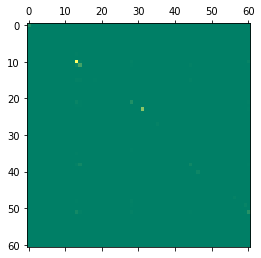

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7.5,5))
plt.matshow(conf_mx, cmap=plt.cm.summer)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<Figure size 540x360 with 0 Axes>

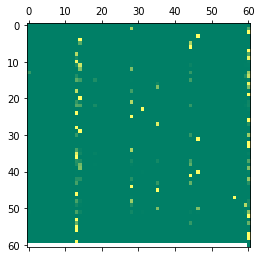

In [20]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(7.5,5))
plt.matshow(norm_conf_mx, cmap=plt.cm.summer)
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       529
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00      4758
          11       0.00      0.00      0.00      1476
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00       224
          16       0.00      0.00      0.00        14
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1